In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.models import load_model

In [3]:
class Data:
    def __init__(self):
        self.dataframe = pd.DataFrame([])

    def read(self, file_name: str):
        self.dataframe = pd.read_csv(file_name)

    def clean_data(self):
        """Remove null values"""
        self.dataframe = self.dataframe.dropna()

    def print_head(self):
        """Print the first few rows of the dataframe"""
        print(self.dataframe.head())

    def print_description(self):
        """Print the statistical description of the dataframe"""
        print(self.dataframe.describe())

    def normalization(self):
        """Normalize the data frame, excluding the Date column"""
        self.scaler = MinMaxScaler(feature_range=(0, 1))
        numeric_columns = self.dataframe.select_dtypes(include=['float64', 'int64']).columns
        # Create a new DataFrame to store the normalized values
        normalized_data = self.scaler.fit_transform(self.dataframe[numeric_columns])
        # Update the original DataFrame with normalized values
        self.dataframe[numeric_columns] = normalized_data

    def visualize_open(self):
        """Plot graph for open stock values v/s date"""
        if 'Date' in self.dataframe.columns and 'Open' in self.dataframe.columns:
            self.dataframe['Date'] = pd.to_datetime(self.dataframe['Date'])
            plt.figure(figsize=(14, 7))
            plt.plot(self.dataframe['Date'], self.dataframe['Open'], label='Open Stock Prices')
            plt.title('Open Stock Prices Over Time')
            plt.xlabel('Date')
            plt.ylabel('Open Stock Price')
            plt.legend()
            plt.show()
        else:
            print("Date and/or Open column not found in the dataframe")

    def visualize_close(self):
        """Plot graph for close stock values v/s date"""
        if 'Date' in self.dataframe.columns and 'Close' in self.dataframe.columns:
            self.dataframe['Date'] = pd.to_datetime(self.dataframe['Date'])
            plt.figure(figsize=(14, 7))
            plt.plot(self.dataframe['Date'], self.dataframe['Close'], label='Close Stock Prices')
            plt.title('Close Stock Prices Over Time')
            plt.xlabel('Date')
            plt.ylabel('Close Stock Price')
            plt.legend()
            plt.show()
        else:
            print("Date and/or Close column not found in the dataframe")

In [4]:
data = Data()

In [5]:
data.read('SBIN.NS.csv')

In [6]:
data.clean_data()

In [7]:
data.print_head()
data.print_description()

         Date        Open        High         Low       Close   Adj Close  \
0  2019-05-31  354.350006  357.899994  344.649994  352.500000  331.788635   
1  2019-06-03  352.350006  356.450012  349.649994  355.450012  334.565338   
2  2019-06-04  354.000000  357.200012  351.399994  352.399994  331.694519   
3  2019-06-06  349.000000  349.600006  335.899994  336.899994  317.105194   
4  2019-06-07  337.000000  342.750000  336.000000  342.049988  321.952606   

     Volume  
0  32588069  
1  18380919  
2  18130636  
3  41941144  
4  29739710  
              Open         High          Low        Close    Adj Close  \
count  1236.000000  1236.000000  1236.000000  1236.000000  1236.000000   
mean    444.471360   449.609507   438.708980   444.116505   426.991310   
std     161.675055   162.631006   160.854066   161.809665   161.807725   
min     151.949997   153.199997   149.449997   150.850006   141.986725   
25%     316.162506   321.925003   312.687492   317.449990   298.798027   
50%     4

In [8]:
data.normalization()

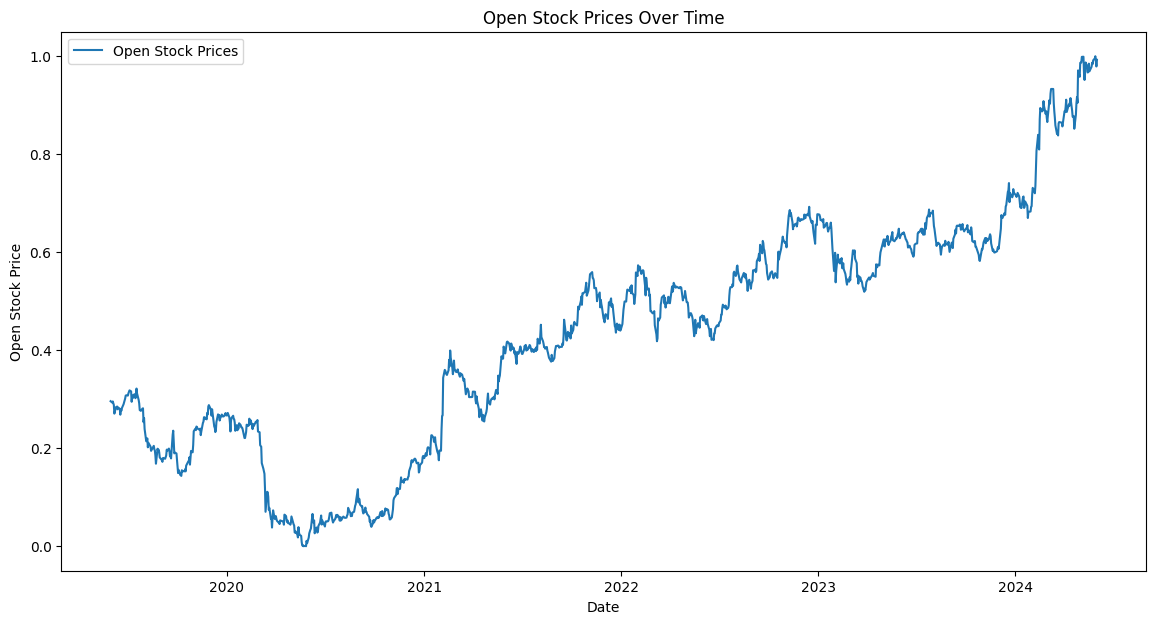

In [9]:
data.visualize_open()

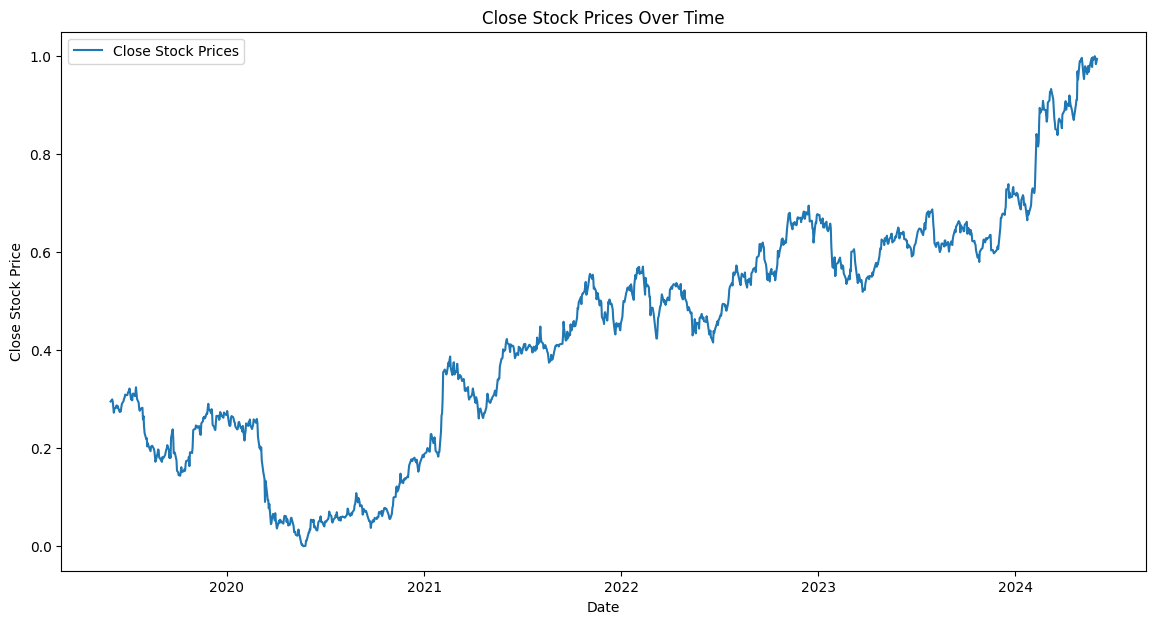

In [10]:
data.visualize_close()

In [13]:
class LSTMTrainer:
    def __init__(self, dataframe, scaler):
        self.dataframe = dataframe
        self.scaler = scaler

    def prepare_data_for_lstm(self, feature_col='Close', look_back=60):
        """Prepare data for LSTM by creating sequences"""
        data = self.dataframe[feature_col].values
        data = data.reshape(-1, 1)  # Reshape to (n_samples, 1)
        X, y = [], []
        for i in range(len(data) - look_back):
            X.append(data[i:i + look_back])
            y.append(data[i + look_back])
        X, y = np.array(X), np.array(y)
        # Split data while preserving the number of features
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
        return X_train, X_test, y_train, y_test.reshape(-1, 1)

    def build_and_train_lstm(self, feature_col='Close', look_back=60, epochs=100, batch_size=32):
        """Build and train the LSTM model"""
        X_train, X_test, y_train, y_test = self.prepare_data_for_lstm(feature_col, look_back)

        model = Sequential()
        model.add(LSTM(units=50, return_sequences=True, input_shape=(look_back, 1)))
        model.add(LSTM(units=50))
        model.add(Dense(1))

        model.compile(optimizer='adam', loss='mean_squared_error')

        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test))

        self.model = model
        self.X_test = X_test
        self.y_test = y_test


    def predict_and_plot(self):
        """Make predictions and plot the results"""
        predictions = self.model.predict(self.X_test)
        predictions = predictions.reshape(-1, 1)

        # Extract the 'Close' column from the original dataframe
        self.close_scaler = MinMaxScaler(feature_range=(0, 1))  # Create a new scaler for just the 'Close' column
        self.close_scaler.fit(self.dataframe['Close'].values.reshape(-1, 1))  # Fit the scaler to the 'Close' column

        # Inverse transform predictions using the scaler fitted on 'Close' column
        predictions = self.close_scaler.inverse_transform(predictions)
        # Inverse transform actual 'Close' values
        actual = self.close_scaler.inverse_transform(self.y_test)

        plt.figure(figsize=(14, 7))
        plt.plot(actual, label='Actual Stock Price')
        plt.plot(predictions, label='Predicted Stock Price')
        plt.title('Actual vs Predicted Stock Prices')
        plt.xlabel('Time')
        plt.ylabel('Stock Price')
        plt.legend()
        plt.show()


    def evaluate_model(self):
        """Calculates and prints evaluation metrics."""
        predictions = self.model.predict(self.X_test)
        predictions = self.close_scaler.inverse_transform(predictions)  # Assuming you're using the close_scaler
        actual = self.close_scaler.inverse_transform(self.y_test)

        mse = mean_squared_error(actual, predictions)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(actual, predictions)
        r2 = r2_score(actual, predictions)

        print(f"Mean Squared Error (MSE): {mse}")
        print(f"Root Mean Squared Error (RMSE): {rmse}")
        print(f"Mean Absolute Error (MAE): {mae}")
        print(f"R-squared (R2): {r2}")


    def save_model(self, model_path='model.h5'):
        """Save the trained model to a file"""
        self.model.save(model_path)
        print(f"Model saved to {model_path}")

    def load_model(self, model_path='model.h5'):
        """Load a trained model from a file"""
        self.model = load_model(model_path)
        print(f"Model loaded from {model_path}")

In [14]:
trainer = LSTMTrainer(data.dataframe, data.scaler)

In [16]:
trainer.build_and_train_lstm(feature_col='Close', look_back=60, epochs=100, batch_size=32)

Epoch 1/100
30/30 [==============================] - 7s 92ms/step - loss: 0.0306 - val_loss: 0.0027
Epoch 2/100
30/30 [==============================] - 3s 85ms/step - loss: 0.0021 - val_loss: 0.0022
Epoch 3/100
30/30 [==============================] - 2s 77ms/step - loss: 9.6740e-04 - val_loss: 0.0015
Epoch 4/100
30/30 [==============================] - 3s 89ms/step - loss: 9.4865e-04 - val_loss: 0.0018
Epoch 5/100
30/30 [==============================] - 2s 55ms/step - loss: 9.1438e-04 - val_loss: 0.0018
Epoch 6/100
30/30 [==============================] - 2s 50ms/step - loss: 8.9028e-04 - val_loss: 0.0015
Epoch 7/100
30/30 [==============================] - 2s 51ms/step - loss: 9.1896e-04 - val_loss: 0.0019
Epoch 8/100
30/30 [==============================] - 3s 99ms/step - loss: 8.7227e-04 - val_loss: 0.0020
Epoch 9/100
30/30 [==============================] - 2s 51ms/step - loss: 8.1002e-04 - val_loss: 0.0013
Epoch 10/100
30/30 [==============================] - 2s 58ms/step - los

8/8 [==============================] - 1s 20ms/step


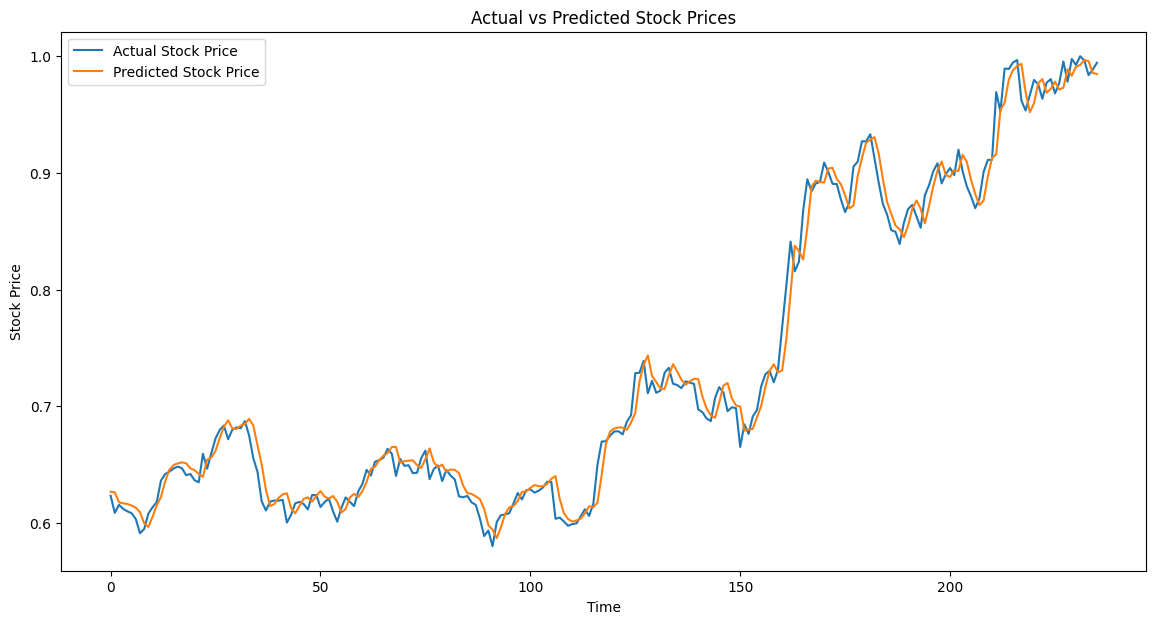

In [17]:
trainer.predict_and_plot()

In [18]:
trainer.evaluate_model()

8/8 [==============================] - 0s 22ms/step
Mean Squared Error (MSE): 0.00020535402618573824
Root Mean Squared Error (RMSE): 0.014330178860912318
Mean Absolute Error (MAE): 0.010595373188871233
R-squared (R2): 0.9881163223222847


In [19]:
trainer.save_model('models/lstm_model.h5')

Model saved to models/lstm_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [20]:
trainer.load_model('models/lstm_model.h5')

Model loaded from models/lstm_model.h5
